cuda:6


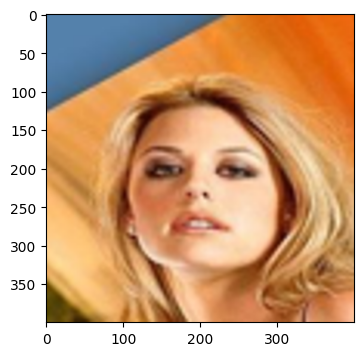

Loaded blender ./data/nerf_synthetic/lego
images (138, 400, 400, 4)
poses (138, 4, 4)


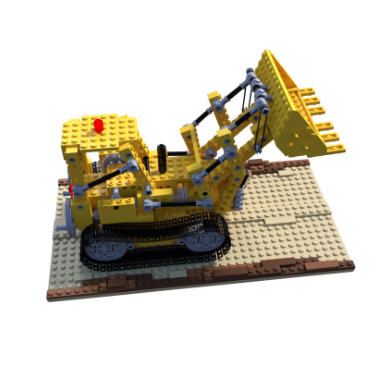

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from load_blender import load_blender_data
from run_nerf_helpers import *
from run_nerf_adv import My_args
from run_nerf_adv import *
from PIL import Image
from numpy import asarray
from torchvision.utils import save_image
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim
import cv2

# default settings
torch.cuda.set_device(6)
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.set_default_tensor_type('torch.cuda.FloatTensor')

# adv_img
im = asarray(Image.open("adv/adv.png").resize((400,400)))
im32 = im.astype(np.float32) / 255.
adv_img = torch.tensor(im32).to(device)
plt.figure(figsize=(10, 4))
plt.imshow(adv_img.detach().cpu().numpy())
plt.show()

# basic args and load data
args = My_args()
images, poses, render_poses, hwf, i_split = load_blender_data(args.datadir, args.half_res, args.testskip)
print('Loaded blender', args.datadir)
print('images', images.shape)
print('poses', poses.shape)
# args.white_bkgd
images = images[...,:3]*images[...,-1:] + (1.-images[...,-1:])
# images = images[...,:3]
H, W, focal = hwf
# H, W = int(H), int(W)
H, W = im.shape[0], im.shape[1]
hwf = [H, W, focal]
K = np.array([
    [focal, 0, 0.5*W],
    [0, focal, 0.5*H],
    [0, 0, 1]
])

# Create log dir and copy the config file
basedir = args.basedir
expname = 'flower_test'
os.makedirs(os.path.join(basedir, expname), exist_ok=True)
# Create nerf model
near = 2.
far = 6.

# Move testing data to GPU
poses = torch.Tensor(poses).to(device)
# show the target_img
target_pose, target_img = poses[5], images[5]
c2w=target_pose[:3,:4]
plt.axis('off')
plt.imshow(target_img)
plt.show()

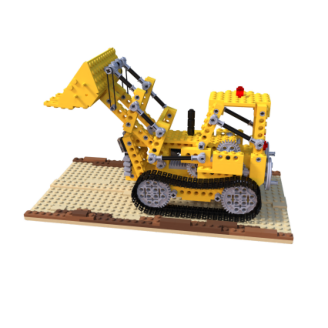

In [2]:
target_pose, target_img = poses[5], images[25]
c2w=target_pose[:3,:4]
plt.figure(figsize=(4, 4))
plt.axis('off')
plt.imshow(target_img)
plt.savefig("chair_wrong.png")
plt.show()

Reloading from ./logs/blender_paper_chair/200000.tar


/home/qhuang/miniconda3/envs/advnerf/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


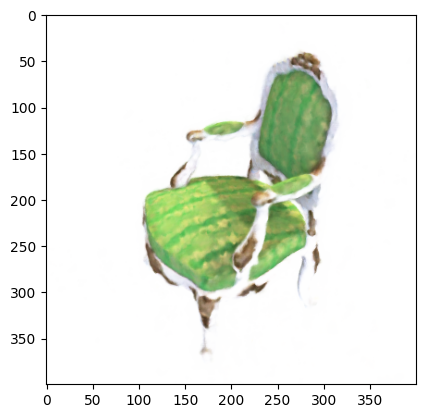

In [3]:
target = images[5]
target = torch.Tensor(target).to(device)
net = get_pretrained_net(args)
rays_o_all, rays_d_all, viewdirs_all, z_vals_all, encoded_points_all = get_encoded_points(H, W, K, rays=None, c2w=c2w, near=near, far=far, use_viewdirs=args.use_viewdirs, N_samples=args.N_samples, args=args)
sh = torch.ones((W,H,3)).shape
with torch.no_grad():
    my_adv_img, disp, acc, extras = encoded_render_new(viewdirs_all, z_vals_all, rays_o_all, rays_d_all, encoded_points_all, net, sh, args=args, chunk=1024*64)
# save_image(torch.permute(my_adv_img, (2, 0, 1)),'result/'+'Local_'+str(N_thresh)+'_opt_'+str(Loop)+'.png')
plt.imshow(my_adv_img.cpu().numpy())
plt.show()

## lr_change

In [3]:
N_thresh = 6144
Loop = 300
# target image
target = images[5]
target = torch.Tensor(target).to(device)
net = get_pretrained_net(args)
# get all encoded points
rays_o_all, rays_d_all, viewdirs_all, z_vals_all, encoded_points_all = get_encoded_points(H, W, K, rays=None, c2w=c2w, near=near, far=far, use_viewdirs=args.use_viewdirs, N_samples=args.N_samples, args=args)
rays_o_all_copy, rays_d_all_copy, viewdirs_all_copy, z_vals_all_copy, encoded_points_all_copy = get_encoded_points(H, W, K, rays=None, c2w=c2w, near=near, far=far, use_viewdirs=args.use_viewdirs, N_samples=args.N_samples, args=args)
# show_image(viewdirs_all, z_vals_all, rays_o_all, rays_d_all, encoded_points_all, net, args, chunk=1024*64)

coords = torch.stack(torch.meshgrid(torch.linspace(0, H-1, H), torch.linspace(0, W-1, W)), -1)
coords = torch.reshape(coords, [-1,2])  # (H * W, 2)

# for i in tqdm(range(0, W*H, N_thresh)):
# for num, i in enumerate(tqdm(range(0, W*H, N_thresh))):
for num, i in enumerate(range(0, W*H, N_thresh)):
    # loop through all pixels 每个像素是肯定要循环的，不然不更新了。

    rays_o, rays_d = get_rays(H, W, K, c2w)
    if N_thresh+i-1 > W*H-1:
        select_inds = torch.linspace(i, W*H-1, N_thresh).long()  # (N_rand,)
    else:
        select_inds = torch.linspace(i, N_thresh+i-1, N_thresh).long()  # (N_rand,)
    select_coords = coords[select_inds].long()  # (N_rand, 2)
    rays_o = rays_o[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
    rays_d = rays_d[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
    viewdirs = viewdirs_all.reshape((400,400,-1))[select_coords[:, 0], select_coords[:, 1]] # (N_rand, 3)
    z_vals = z_vals_all.reshape((400,400,-1))[select_coords[:, 0], select_coords[:, 1]] # (N_rand, 64)
    
    # target and adv img
    target_s = target[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
    adv_img_s = adv_img[select_coords[:, 0], select_coords[:, 1]] # (N_rand, 3)
    
    # encoded_points
    encoded_points = encoded_points_all.reshape((400,400,64,90))[select_coords[:, 0], select_coords[:, 1]].reshape((-1,64,90))
    encoded_points.requires_grad = True

    # adversarial attacking
    lr = 1e-2
    weight_decay=8e-1
    decay_rate = 0.3
    adv_optimizer = torch.optim.AdamW([encoded_points], lr=lr, weight_decay=weight_decay)
    # adv_optimizer = torch.optim.Adam([encoded_points], lr=lr)
    # adv_optimizer = torch.optim.SGD([encoded_points], lr=8e-1, momentum=0.1)
    adv_points = encoded_points.clone()
    global_step = 1
    loss_list = []
    for j in range(Loop): # 主要在这里加trick，以梯度值作为指标。

        if j < 50:
            lr = 1e-1
        else:
            lr = 1e-2
        adv_optimizer.param_groups[0]['lr'] = lr
        
        sh = rays_d.shape
        rgb, disp, acc, extras = encoded_render_new(viewdirs, z_vals, rays_o, rays_d, adv_points, net, sh, chunk=1024*64, args=args)

        loss = torch.nn.functional.mse_loss(rgb, adv_img_s, reduction='sum')
        loss_list.append(loss.item())
        # loss = torch.nn.functional.smooth_l1_loss(rgb, adv_img_s)
        # print('img_loss', loss)
        loss.backward()
        adv_optimizer.step()
        adv_optimizer.zero_grad()
        adv_points = adv_optimizer.param_groups[0]['params'][0]

        # ###   update learning rate and weight_decay  ###
        new_lrate = lr * (decay_rate ** (global_step / Loop))
        for param_group in adv_optimizer.param_groups:
            param_group['lr'] = new_lrate

        new_weight_decay = weight_decay * (decay_rate ** (global_step / Loop))
        for param_group in adv_optimizer.param_groups:
            param_group['weight_decay'] = new_weight_decay


        global_step = global_step + 1
        # #################################################

    file = open("record/"+str(num+1)+".txt", "w")
    for cont, item in enumerate(loss_list):
        file.write(str(cont+1) + "\t" + str(item) + "\n")
    file.close()
    print(num+1, 'img_loss', loss)
    encoded_points.requires_grad = False
    encoded_points_all.reshape((400,400,64,90))[select_coords[:, 0], select_coords[:, 1]] = adv_points

Reloading from ./logs/blender_lego/130000.tar


/home/qhuang/miniconda3/envs/advnerf/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


1 img_loss tensor(3.5720, grad_fn=<MseLossBackward0>)
2 img_loss tensor(3.2597, grad_fn=<MseLossBackward0>)
3 img_loss tensor(3.6221, grad_fn=<MseLossBackward0>)
4 img_loss tensor(3.5285, grad_fn=<MseLossBackward0>)
5 img_loss tensor(3.2977, grad_fn=<MseLossBackward0>)
6 img_loss tensor(3.0731, grad_fn=<MseLossBackward0>)
7 img_loss tensor(1.5122, grad_fn=<MseLossBackward0>)
8 img_loss tensor(1.3635, grad_fn=<MseLossBackward0>)
9 img_loss tensor(2.2389, grad_fn=<MseLossBackward0>)
10 img_loss tensor(2.9173, grad_fn=<MseLossBackward0>)
11 img_loss tensor(3.5052, grad_fn=<MseLossBackward0>)
12 img_loss tensor(3.8109, grad_fn=<MseLossBackward0>)
13 img_loss tensor(2.6831, grad_fn=<MseLossBackward0>)
14 img_loss tensor(2.0933, grad_fn=<MseLossBackward0>)
15 img_loss tensor(2.7332, grad_fn=<MseLossBackward0>)
16 img_loss tensor(3.5402, grad_fn=<MseLossBackward0>)
17 img_loss tensor(3.6967, grad_fn=<MseLossBackward0>)
18 img_loss tensor(5.4382, grad_fn=<MseLossBackward0>)
19 img_loss tensor(

/home/qhuang/miniconda3/envs/advnerf/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  # Remove the CWD from sys.path while we load stuff.


ssim = 0.9769686


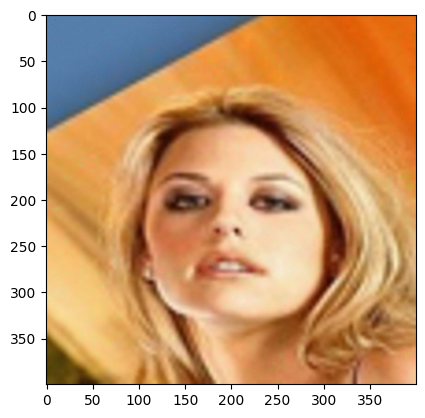

In [4]:
noise = encoded_points_all - encoded_points_all_copy
# torch.save(noise, 'result/'+'Local_'+str(N_thresh)+'_opt_'+str(Loop)+'.pt')
torch.save(noise, 'test.pt')

sh = torch.ones((400,400,3)).shape
with torch.no_grad():
    my_adv_img, disp, acc, extras = encoded_render_new(viewdirs_all_copy, z_vals_all_copy, rays_o_all_copy, rays_d_all_copy, encoded_points_all_copy+noise, net, sh, args=args, chunk=1024*64)
# save_image(torch.permute(my_adv_img, (2, 0, 1)),'result/'+'Local_'+str(N_thresh)+'_opt_'+str(Loop)+'.png')
# save_image(torch.permute(my_adv_img, (2, 0, 1)),'50.png')
s = ssim(my_adv_img.cpu().numpy(), adv_img.cpu().numpy(), multichannel=True)
print("ssim =", s)
save_image(torch.permute(my_adv_img, (2, 0, 1)), str(Loop)+'_'+str(s)+'.png')
plt.axis('off')
plt.imshow(my_adv_img.cpu().numpy())
plt.show()

In [4]:
torch.save(noise, 'best.pt')

In [5]:
print("ssim = ", ssim(my_adv_img.cpu().numpy(), adv_img.cpu().numpy(), multichannel=True))

ssim =  0.9769686


/home/qhuang/miniconda3/envs/advnerf/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  """Entry point for launching an IPython kernel.


## Evaluation

Reloading from ./logs/blender_lego/130000.tar


/home/qhuang/miniconda3/envs/advnerf/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/qhuang/miniconda3/envs/advnerf/lib/python3.7/site-packages/ipykernel_launcher.py:52: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.


ssim =  0.9769686


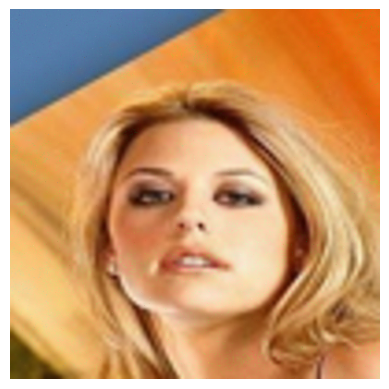

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
from torchvision.utils import save_image
from run_nerf_adv import *
from run_nerf_adv import My_args_chair
from skimage.metrics import structural_similarity as ssim


torch.cuda.set_device(5)
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type('torch.cuda.FloatTensor')

im = np.asarray(Image.open("adv/adv.png").resize((400,400)))
im32 = im.astype(np.float32) / 255.
adv_img = torch.tensor(im32).to(device)

args = My_args()
args.device = device
images, poses, render_poses, hwf, i_split = load_blender_data(args.datadir, args.half_res, args.testskip)
# args.white_bkgd
images = images[...,:3]*images[...,-1:] + (1.-images[...,-1:])
H, W, focal = hwf
H, W = int(H), int(W)
hwf = [H, W, focal]
K = np.array([
    [focal, 0, 0.5*W],
    [0, focal, 0.5*H],
    [0, 0, 1]
])
near = 2.
far = 6.
# Move testing data to GPU
poses = torch.Tensor(poses).to(device)
# show the target_img
target_pose, target_img = poses[5], images[5]
c2w=target_pose[:3,:4]


net = get_pretrained_net(args)
rays_o_all_copy, rays_d_all_copy, viewdirs_all_copy, z_vals_all_copy, encoded_points_all_copy = get_encoded_points(H, W, K, rays=None, c2w=c2w, near=near, far=far, use_viewdirs=args.use_viewdirs, N_samples=args.N_samples, args=args)

N_thresh = 6144
Loop = 2000
# load_noise = torch.load('result/'+'Local_'+str(N_thresh)+'_opt_'+str(Loop)+'.pt')
load_noise = torch.load('test.pt').to(device)

sh = torch.ones((400,400,3)).shape
with torch.no_grad():
    my_adv_img, disp, acc, extras = encoded_render_new(viewdirs_all_copy, z_vals_all_copy, rays_o_all_copy, rays_d_all_copy, encoded_points_all_copy+load_noise, net, sh, args=args, chunk=1024*64)
print("ssim = ", ssim(my_adv_img.cpu().numpy(), adv_img.cpu().numpy(), multichannel=True))
save_image(torch.permute(my_adv_img, (2, 0, 1)), 'test_wrong.png')
plt.axis('off')
plt.imshow(my_adv_img.cpu().numpy())
plt.show()

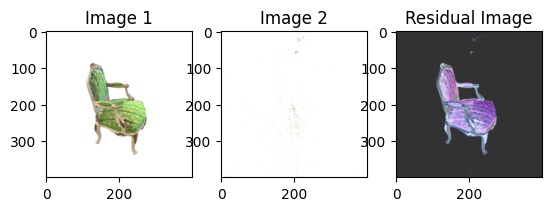

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 读取两张图片
image1 = cv2.imread('chair_wrong.png')
image2 = cv2.imread('test_wrong.png')

# # 确保两张图片具有相同的大小
# image1 = cv2.resize(image1, (image2.shape[1], image2.shape[0]))

# 计算两张图片的残差
residual_image = cv2.absdiff(image1, image2)

# 增加对比度以突出残差
residual_image = cv2.convertScaleAbs(residual_image, alpha=1, beta=50)

cv2.imwrite('residual_image.png', residual_image)

# 显示原始图片和残差图片
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.title('Image 1')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.title('Image 2')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(residual_image, cv2.COLOR_BGR2RGB))
plt.title('Residual Image')

plt.show()

In [1]:
# import module
from PIL import Image, ImageChops, ImageEnhance

# assign images
img1 = Image.open('adv/input.png')
img2 = Image.open('test_wrong.png')
# finding difference
diff = ImageChops.difference(img1, img2)

enhancer = ImageEnhance.Contrast(diff)
image_adjusted = enhancer.enhance(1)


# diff.save("diff.png")
image_adjusted

FileNotFoundError: [Errno 2] No such file or directory: 'test_wrong.png'

## utils

### save and load images

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.utils import save_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# adv_img
im = np.asarray(Image.open("adv/adv.png").resize((400,400)))
im32 = im.astype(np.float32) / 255.
# imageio.imwrite('filename.png', np.uint8(im32*255))


adv_img = torch.tensor(im32).to(device)
save_image(torch.permute(adv_img, (2, 0, 1)),'white.png')


plt.figure(figsize=(10, 4))
plt.imshow(adv_img.detach().cpu().numpy())
plt.show()

### network

In [ ]:
embed_fn, input_ch = get_embedder(args.multires, args.i_embed)
embeddirs_fn, input_ch_views = get_embedder(args.multires_views, args.i_embed)
output_ch = 5 if args.N_importance > 0 else 4
skips = [4]
network_fn = NeRF(D=args.netdepth, W=args.netwidth,
                 input_ch=input_ch, output_ch=output_ch, skips=skips,
                 input_ch_views=input_ch_views, use_viewdirs=args.use_viewdirs).to(args.device)

network_fine = NeRF(D=args.netdepth_fine, W=args.netwidth_fine,
                          input_ch=input_ch, output_ch=output_ch, skips=skips,
                          input_ch_views=input_ch_views, use_viewdirs=args.use_viewdirs).to(args.device)

ckpts = [os.path.join(args.basedir, args.expname, f) for f in sorted(os.listdir(os.path.join(args.basedir, args.expname))) if 'tar' in f]
ckpt_path = ckpts[-1]
print('Reloading from', ckpt_path)
ckpt = torch.load(ckpt_path)

# Load model
network_fn.load_state_dict(ckpt['network_fn_state_dict'])
network_fine.load_state_dict(ckpt['network_fine_state_dict'])
# network_fn.parameters
for name, para in network_fn.named_parameters():
    para.requires_grad_(False)
    # 或者 para.requires_grad = False
for name, para in network_fine.named_parameters():
    para.requires_grad_(False)
    # 或者 para.requires_grad = False
net = {
        'network_fine' : network_fine,
        'network_fn' : network_fn,
    }

### sample pixel

In [ ]:
N_rand = 1024
target = images[5]
target = torch.Tensor(target).to(device)
# get all encoded points
rays_o_all, rays_d_all, viewdirs_all, z_vals_all, encoded_points_all = get_encoded_points(H, W, K, rays=None, c2w=c2w, near=near, far=far, use_viewdirs=args.use_viewdirs, N_samples=args.N_samples, args=args)
rays_o_all_copy, rays_d_all_copy, viewdirs_all_copy, z_vals_all_copy, encoded_points_all_copy = get_encoded_points(H, W, K, rays=None, c2w=c2w, near=near, far=far, use_viewdirs=args.use_viewdirs, N_samples=args.N_samples, args=args)
show_image(viewdirs_all, z_vals_all, rays_o_all, rays_d_all, encoded_points_all, net, args, chunk=1024*64)

# Sampling pixels and adversarial attacking
for i in tqdm(range(1000)):
    # basic settings
    rays_o, rays_d = get_rays(H, W, K, c2w)
    coords = torch.stack(torch.meshgrid(torch.linspace(0, H-1, H), torch.linspace(0, W-1, W)), -1)
    coords = torch.reshape(coords, [-1,2])  # (H * W, 2)
    select_inds = np.random.choice(coords.shape[0], size=[N_rand], replace=False)  # (N_rand,)
    select_coords = coords[select_inds].long()  # (N_rand, 2)
    rays_o = rays_o[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
    rays_d = rays_d[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
    viewdirs = viewdirs_all.reshape((400,400,-1))[select_coords[:, 0], select_coords[:, 1]] # (N_rand, 3)
    z_vals = z_vals_all.reshape((400,400,-1))[select_coords[:, 0], select_coords[:, 1]] # (N_rand, 64)
    
    # target and adv img
    target_s = target[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
    adv_img_s = adv_img[select_coords[:, 0], select_coords[:, 1]] # (N_rand, 3)
    
    # encoded_points
    encoded_points = encoded_points_all.reshape((400,400,64,90))[select_coords[:, 0], select_coords[:, 1]].reshape((-1,64,90))
    encoded_points.requires_grad = True

    # adversarial attacking
    adv_optimizer = torch.optim.AdamW([encoded_points], lr=1e-1, weight_decay=0.1)
    adv_points = encoded_points.clone()
    for j in range(50):
        sh = rays_d.shape
        rgb, disp, acc, extras = encoded_render_new(viewdirs, z_vals, rays_o, rays_d, adv_points, net, sh, chunk=1024*64, args=args)

        loss = torch.nn.functional.mse_loss(rgb, adv_img_s)
        # loss = torch.nn.functional.smooth_l1_loss(rgb, adv_img_s)
        # print('img_loss', loss)
        loss.backward()
        adv_optimizer.step()
        adv_optimizer.zero_grad()
        adv_points = adv_optimizer.param_groups[0]['params'][0]
        
    encoded_points.requires_grad = False
    encoded_points_all.reshape((400,400,64,90))[select_coords[:, 0], select_coords[:, 1]] = adv_points